# Project

In [795]:
NUM_ITERS = 1000000
DPI_PLOTS = 100
MAX_RUNTIME = 2
FRAME_ANIMATION = 100

In [796]:
# from  sklearn.datasets import load_diabetes
from tensorflow import keras
import math
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [797]:
#data, targets = load_diabetes(return_X_y=True)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test))
targets = np.concatenate((y_train, y_test))
data = data[np.logical_or(targets == 0, targets == 1)]
targets = targets[np.logical_or(targets == 0, targets == 1)]
data = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
#data = np.hstack((data, np.ones((data.shape[0],1))))

$$
s=r \rightarrow 2*\sum_{i=0}^n(x_s^i)x_s^i \\
s\neq r \rightarrow 2*\sum_{i=0}^n(x_r^i)x_s^i
$$

In [798]:
starting_point = np.ones(data.shape[1])

In [799]:
# weights_count = data.shape[1]
# hessian = np.zeros((weights_count, weights_count))
# for i in range(weights_count):
#     for j in range(weights_count):
#         if i == j:
#             hessian[i, j] = data[:,i].T@data[:,i] * 2
#         else:
#             hessian[i, j] = data[:,i].T@data[:,j] * 2
#
# eigenvalues = np.linalg.eig(hessian)[0]
# L = np.max(eigenvalues)
# sigma = np.min(eigenvalues)
# STEPSIZE = 1 / L # 2 / (L + sigma)

## Loss & Grad

In [800]:
def loss_mse(data, targets, w):
    return np.square(data@w - targets).mean()

def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)

def grad_mse_single(sample, params, target):
    return -1 * (target - sample @ params) * sample


def loss_robust_lin_reg_single(data, targets, w):
    return np.log(np.square(targets - data@w)/2 + 1).mean()

def grad_robust_lin_reg_single(sample, w, target):
    temp = 1/((target - sample@w)**2 / 2 + 1) * (target - sample@w)
    return np.array([
        temp * -sample[j]
        for j in range(len(w))
    ])
def grad_robust_lin_reg_array(data, w, targets):
    return np.mean([
        grad_robust_lin_reg_single(data[index], w, targets[index])
        for index in range(len(data))
    ], axis=0)

def loss(data, w, targets):
    return loss_robust_lin_reg_single(data, targets, w)
    #return loss_mse(data, targets, w)

def grad_single(sample, w, target):
    return grad_robust_lin_reg_single(sample, w, target)
    #return grad_mse_single(sample, w, target)

def grad_array(data, w, targets):
    return grad_robust_lin_reg_array(data, w, targets)
    #return grad_mse_array(data, w, targets)

In [801]:
# chunked_data = data.reshape((data.shape[0], -1, data.shape[1]))
# chunked_target = targets.reshape((data.shape[0], -1))

## SGD

In [802]:
w = np.copy(starting_point)
track_error_sgd = [loss(data, w, targets)]
track_time_sgd = [0]
track_w_sgd = [w]
time_counter = time.time()
start =  time.time()
step = 0.001

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    w = w - step * grad_single(data[index], w, targets[index])
    step *= .99

    track_time_sgd.append(time.time() - start)
    track_error_sgd.append(loss(data, w, targets))
    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
        time_counter = time.time()
        track_w_sgd.append(w)

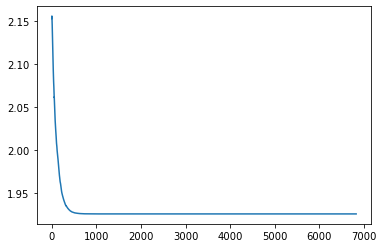

In [803]:
import matplotlib.pyplot as plt
plt.plot(track_error_sgd)

## SAG

In [804]:
w = np.copy(starting_point)
track_error_sag = [loss(data, w, targets)]
start =  time.time()
track_w_sag = [w]
time_counter = time.time()
track_time_sag = [0]
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = 0.0005

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    g[index] = grad_single(data[index], w, targets[index])
    w = w - step * np.mean(g, axis=0)

    track_time_sag.append(time.time() - start)
    track_error_sag.append(loss(data, w, targets))
    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
        time_counter = time.time()
        track_w_sag.append(w)
    step *= .99

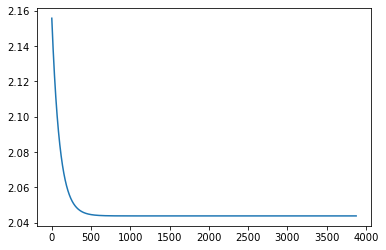

In [805]:
import matplotlib.pyplot as plt
plt.plot(track_error_sag)

## SAGA

In [806]:
w = np.copy(starting_point)
track_error_saga = [loss(data, w, targets)]
start =  time.time()
track_time_saga = [0]
track_w_saga = [w]
time_counter = time.time()
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    gradient = grad_single(data[index], w, targets[index])
    w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
    g[index] = gradient
    step *= .99

    track_time_saga.append(time.time() - start)
    track_error_saga.append(loss(data, w, targets))

    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
        time_counter = time.time()
        track_w_saga.append(w)

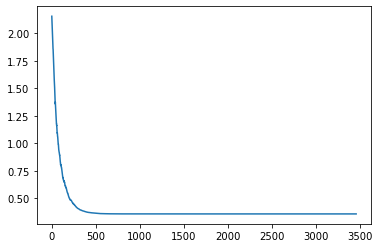

In [807]:
import matplotlib.pyplot as plt
plt.plot(track_error_saga)

## SVGR

In [808]:
w = np.copy(starting_point)
track_error_svrg = [loss(data, w, targets)]
start =  time.time()
track_time_svrg = [0]
track_w_svrg = [w]
time_counter = time.time()
step = 0.005

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_tilde = np.copy(w)
    avg_gradients = np.mean([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])], axis=0)
    for j in range(data.shape[0] // 8):
        index = np.random.randint(0, data.shape[0])
        current_grad = grad_single(data[index], w, targets[index])
        w = w - step * (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_tilde, targets[index]) +
                avg_gradients
        )
        track_time_svrg.append(time.time() - start)
        track_error_svrg.append(loss(data, w, targets))
        if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
            time_counter = time.time()
            track_w_svrg.append(w)
    step *= .99


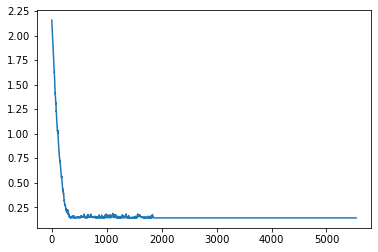

In [809]:
import matplotlib.pyplot as plt
plt.plot(track_error_svrg)

## SARAH

In [810]:
w = np.copy(starting_point)
track_error_sarah = [loss(data, w, targets)]
start =  time.time()
track_time_sarah = [0]
track_w_sarah = [w]
time_counter = time.time()
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_0 = np.copy(w)
    v_0 = grad_array(data, w, targets)
    w = w_0 - step * v_0
    for t in range(np.random.randint(0, data.shape[0] // 2)):
        index = np.random.randint(0, data.shape[0])
        v_0 = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_0
        )
        w_0 = np.copy(w)
        w = w - step * v_0

        track_time_sarah.append(time.time() - start)
        track_error_sarah.append(loss(data, w, targets))
        if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
            time_counter = time.time()
            track_w_sarah.append(w)
    step *= .99

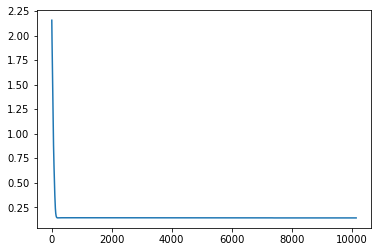

In [811]:
import matplotlib.pyplot as plt
plt.plot(track_error_sarah)

## SARAH+

In [812]:
w = np.copy(starting_point)
track_error_sarah_plus = [loss(data, w, targets)]
start =  time.time()
track_time_sarah_plus = [0]
track_w_sarah_plus = [w]
time_counter = time.time()
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_0 = np.copy(w)
    v_0 = grad_array(data, w, targets)
    w = w_0 - step * v_0
    v_t = np.copy(v_0)
    for t in range(data.shape[0] // 2):
        if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
            break
        index = np.random.randint(0, data.shape[0])
        v_t = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_t
        )
        w_0 = np.copy(w)
        w = w - step * v_t

        track_time_sarah_plus.append(time.time() - start)
        track_error_sarah_plus.append(loss(data, w, targets))
        if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
            time_counter = time.time()
            track_w_sarah_plus.append(w)
    step *= .99

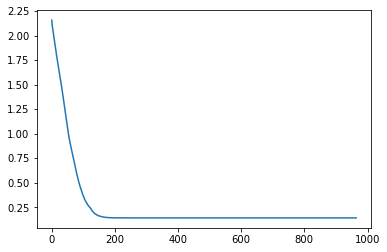

In [813]:
import matplotlib.pyplot as plt
plt.plot(track_error_sarah_plus)

## SpiderBoost

In [834]:
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_error_spider_boost = [loss(data, w, targets)]
track_time_spider_boost = [0]
track_w_spider_boost = [w]
time_counter = time.time()

start =  time.time()
step = 0.2

q = int(math.sqrt(data.shape[0]))
all_indexes = list(range(data.shape[0]))
v_previous = grad_array(data, w, targets)

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    if  i % q == 0:
        vk = grad_array(data, w, targets)
    else:
        sample_indexes = np.random.choice(all_indexes, q)
        samples_data = data[sample_indexes]
        samples_targets = targets[sample_indexes]

        first = grad_array(samples_data, w, samples_targets)
        second = grad_array(samples_data, w_previous, samples_targets)
        vk = (first - second) + v_previous


    w_previous = np.copy(w)
    v_previous = np.copy(vk)
    w = w - step * vk
    track_time_spider_boost.append(time.time() - start)
    track_error_spider_boost.append(loss(data, w, targets))
    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
        time_counter = time.time()
        track_w_spider_boost.append(w)
    step *= .99

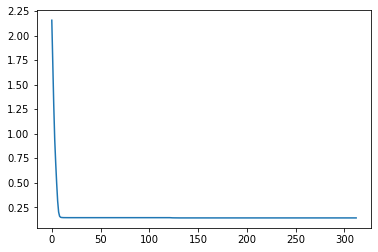

In [835]:
import matplotlib.pyplot as plt
plt.plot(track_error_spider_boost)

## SNVRG

In [816]:
def updateReferencePoints(wl_old, w, r, K):
    wl_new  = []
    for l in range(r):
        wl_new.append(wl_old[l])
    for l in range(r, K+1):
        wl_new.append(w)
    return np.array(wl_new)

def updateReferenceGradients(gl_old, wl_new, r, K, Bl):
    gl_new  = []
    for l in range(r):
        gl_new.append(gl_old[l])
    for l in range(r, K+1):
        indexes = np.random.choice(list(range(data.shape[0])), Bl, replace=False)
        #print(data[indexes].shape, targets[indexes].shape, wl_new[l].shape)
        gl_new.append(grad_array(data[indexes], wl_new[l], targets[indexes]) - \
                    grad_array(data[indexes], wl_new[l-1], targets[indexes]))
    return gl_new

def oneEpochSNVRG(w, M):
    w = np.copy(w)
    K = 2
    B = 128
    b = 2
    Bl = np.array([B/(b**(i+1)) for i in range(K+1)]).astype("int")
    Tl = np.array([b for _ in range(K+1)])
    wl = np.array([w for _ in range(K+1)])
    wl_previous = np.array([w for _ in range(K+1)])
    wl_history = [[w for _ in range(K+1)]]
    gl = np.array([np.zeros(np.shape(w)).tolist() for _ in range(K+1)])
    indexes = np.random.choice(list(range(data.shape[0])), B, replace=False)
    gl[0] = grad_array(data[indexes], w, targets[indexes])
    v = np.sum(gl, axis=0)
    w = w - 1/(10 * M) * v
    wl_history.append(np.copy(w))
    for t in range(1, np.prod(Tl) - 1):
        r = 0
        for j in range( K + 1):
            if t % np.prod(Tl[j+1:]) == 0:
                r = j
                break
        for l in range(K):
            wl = updateReferencePoints(wl_previous, w, r, K)
        for l in range(K):
            gl = updateReferenceGradients(gl, wl, r, K, Bl[l])

        v = np.sum(gl, axis=0)
        wl_previous = np.copy(wl)
        w = w - 1/(10 * M) * v
        wl_history.append(np.copy(w))

    return wl_history[np.random.randint(wl.shape[0] - 1)], w

In [817]:
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_error_snvrg = [loss(data, w, targets)]
track_time_snvrg = [0]
track_w_snvrg = [w]
time_counter = time.time()

start =  time.time()
M = 0.8

for i in range(np.random.randint(NUM_ITERS)):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    y_s, w = oneEpochSNVRG(w, M)

    track_time_snvrg.append(time.time() - start)
    track_error_snvrg.append(loss(data, w, targets))
    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
        time_counter = time.time()
        track_w_snvrg.append(w)

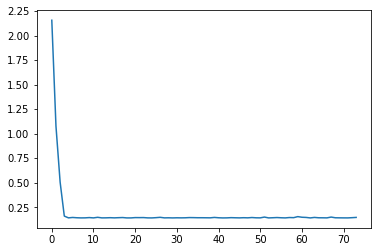

In [818]:
import matplotlib.pyplot as plt
plt.plot(track_error_snvrg)

## Plots

In [836]:
track_time_sgd = np.array(track_time_sgd)
track_time_sag = np.array(track_time_sag)
track_time_saga = np.array(track_time_saga)
track_time_sarah = np.array(track_time_sarah)
track_time_sarah_plus = np.array(track_time_sarah_plus)
track_time_spider_boost = np.array(track_time_spider_boost)
track_time_svrg = np.array(track_time_svrg)
track_time_snvrg = np.array(track_time_snvrg)

track_error_sgd = np.array(track_error_sgd)
track_error_sag = np.array(track_error_sag)
track_error_saga = np.array(track_error_saga)
track_error_sarah = np.array(track_error_sarah)
track_error_sarah_plus = np.array(track_error_sarah_plus)
track_error_spider_boost = np.array(track_error_spider_boost)
track_error_svrg = np.array(track_error_svrg)
track_error_snvrg = np.array(track_error_snvrg)


track_error_sgd = track_error_sgd[track_time_sgd < MAX_RUNTIME]
track_error_sag = track_error_sag[track_time_sag < MAX_RUNTIME]
track_error_saga = track_error_saga[track_time_saga < MAX_RUNTIME]
track_error_sarah = track_error_sarah[track_time_sarah < MAX_RUNTIME]
track_error_sarah_plus = track_error_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
track_error_spider_boost = track_error_spider_boost[track_time_spider_boost < MAX_RUNTIME]
track_error_svrg = track_error_svrg[track_time_svrg < MAX_RUNTIME]
track_error_snvrg = track_error_snvrg[track_time_snvrg < MAX_RUNTIME]

track_time_sgd = track_time_sgd[track_time_sgd < MAX_RUNTIME]
track_time_sag = track_time_sag[track_time_sag < MAX_RUNTIME]
track_time_saga = track_time_saga[track_time_saga < MAX_RUNTIME]
track_time_sarah = track_time_sarah[track_time_sarah < MAX_RUNTIME]
track_time_sarah_plus = track_time_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
track_time_spider_boost = track_time_spider_boost[track_time_spider_boost < MAX_RUNTIME]
track_time_svrg = track_time_svrg[track_time_svrg < MAX_RUNTIME]
track_time_snvrg = track_time_snvrg[track_time_snvrg < MAX_RUNTIME]

In [837]:
min = np.min(
    np.concatenate((
        track_error_sarah,
        track_error_sarah_plus,
        track_error_snvrg,
        track_error_sag,
        track_error_saga,
        track_error_snvrg,
        track_error_spider_boost,
        track_error_sgd
    ))
)

In [838]:
min

0.14203872051452684

### Iterations

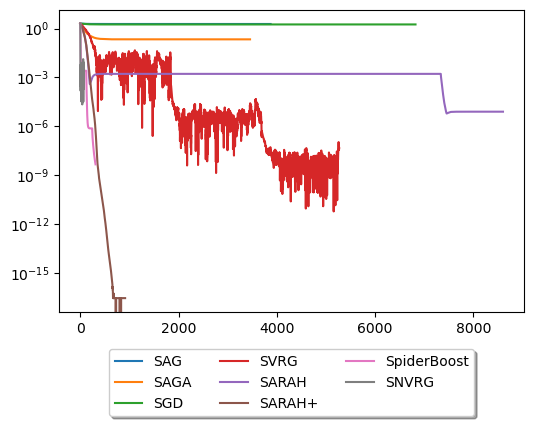

In [839]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)

plt.semilogy(track_error_sag - min)
plt.semilogy(track_error_saga - min)
plt.semilogy(track_error_sgd - min)
plt.semilogy(track_error_svrg - min)
plt.semilogy(track_error_sarah - min)
plt.semilogy(track_error_sarah_plus - min)
plt.semilogy(track_error_spider_boost - min)
plt.semilogy(track_error_snvrg - min)

# Put a legend below current axis
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)


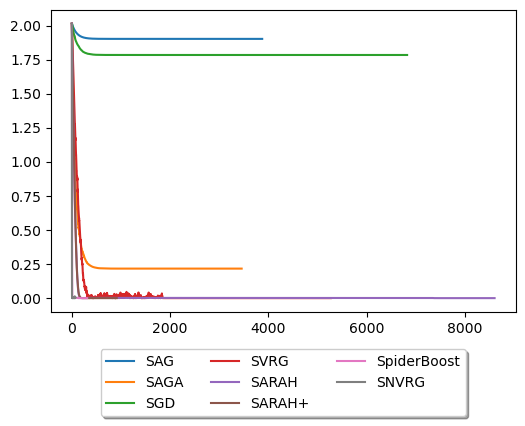

In [840]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_error_sag - min)
plt.plot(track_error_saga - min)
plt.plot(track_error_sgd - min)
plt.plot(track_error_svrg - min)
plt.plot(track_error_sarah - min)
plt.plot(track_error_sarah_plus - min)
plt.plot(track_error_spider_boost - min)
plt.plot(track_error_snvrg - min)
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Time

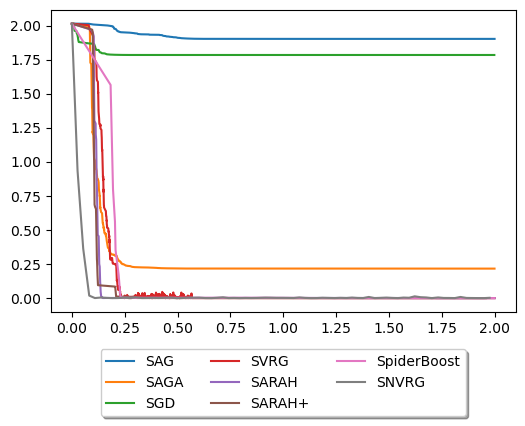

In [841]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_error_sag - min)
plt.plot(track_time_saga, track_error_saga - min)
plt.plot(track_time_sgd, track_error_sgd - min)
plt.plot(track_time_svrg, track_error_svrg - min)
plt.plot(track_time_sarah, track_error_sarah - min)
plt.plot(track_time_sarah_plus, track_error_sarah_plus - min)
plt.plot(track_time_spider_boost, track_error_spider_boost - min)
plt.plot(track_time_snvrg, track_error_snvrg - min)
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

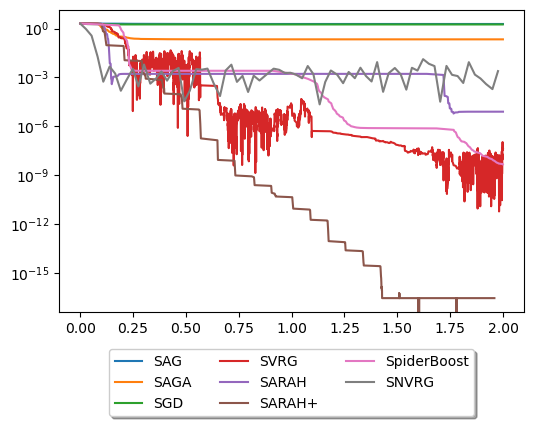

In [842]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_error_sag - min)
plt.semilogy(track_time_saga, track_error_saga - min)
plt.semilogy(track_time_sgd, track_error_sgd - min)
plt.semilogy(track_time_svrg, track_error_svrg - min)
plt.semilogy(track_time_sarah, track_error_sarah - min)
plt.semilogy(track_time_sarah_plus, track_error_sarah_plus - min)
plt.semilogy(track_time_spider_boost, track_error_spider_boost - min)
plt.semilogy(track_time_snvrg, track_error_snvrg - min)
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

## Animation

In [827]:
import plotly.graph_objects as go

x = np.linspace(-300, 300, 100)
y = np.linspace(-300, 300, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([
    [loss(data, [x,y], targets) for x,y in zip(x_r, y_r)]
    for x_r, y_r in zip(X,Y)
])



figure_data = [
    go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),
]
tracks = [
    track_w_sgd,
    track_w_sag,
    track_w_saga,
    track_w_svrg,
    track_w_sarah,
    track_w_sarah_plus,
    track_w_spider_boost,
    track_w_snvrg
]
names = [
    "SGD", "SAG", "SAGA", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"
]


only_each_n = 3
for i, (track, name) in enumerate(zip(tracks, names)):
    track = track[::only_each_n]
    xx, yy = np.hsplit(np.array(track),2)
    zz = np.array([loss(data, w_, targets) for w_ in track])
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = zz.reshape(-1)
    color = int(i/len(tracks)*255)
    figure_data.append(
        go.Scatter3d(
            name=name,
            x=xx, y=yy, z=zz,
            marker=dict(
                size=10,
                color=f"hsl({color}, 100%, 50%)",
                colorscale='Viridis',
            ),
            line=dict(
                color=f"hsl({color}, 100%, 50%)",
                width=2
            )
        )
    )

fig = go.Figure(data=figure_data)

fig.update_layout(
    width=800,height=700,autosize=False,
    scene=dict(
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)

camera = dict(
    up=dict(x= 0, y=0, z= 1),
    center=dict(x= 0, y=0, z=0),
    eye=dict(x=-0.8023838506027073,y=-1.3178773620783153,z=1.0871427757261114)
)
fig.update_layout(scene_camera=camera)

fig.show()


# USED TO FIND CAMERA
# import plotly.graph_objects as go
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
# app = dash.Dash()
# app.layout = html.Div([
#     html.Div(id="output"),        # use to print current relayout values
#     dcc.Graph(id="fig", figure=fig)
# ])
# @app.callback(
#     Output("output", "children"),
#     Input("fig", "relayoutData")
# )
# def show_data(data):
#     # show camera settings like eye upon change
#     return [str(data)]
# app.run_server(debug=False, use_reloader=False)

